In [1]:
#Imports

import sys

import pandas as pd

import scipy
from scipy import stats

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import plot_importance

#outside scripts
%aimport dataclean
%aimport datapull
%aimport gen_results

In [2]:
#quandl pull

dataset = datapull.quandl_pull('datasources2.csv')

In [3]:
#yieldcurve pull

yields = datapull.yieldcurve_pull('Fed10Y_3M.csv')

In [4]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [5]:
#offsetting dataset to simulate data release timing

dataset = dataclean.timing_offset(dataset)

In [6]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)
dataset = dataset.drop(columns = ['GDP']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [7]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [8]:
#refining dataframe period to be 1959 to present. NOTE: this will need to be adjusted when run in the future

dataset = dataset[552:]
dataset = dataset[:-11]

In [9]:
#substituting mean value in for missing values and adding dummy column to indicate where done.

for col in dataset.columns:
    if str(col)=='Recession':
        continue
    dataclean.clean_zeros(col, dataset)

In [10]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [11]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        if 'PXY' in str(col): #adding logic so it doesn't create a momentum column out of PXY columns
            continue
        dataclean.create_momentum(col,dataset,i)

In [12]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [13]:
#split off X and y from base dataframe

y = dataset['Recession']
dataset = dataset.drop(columns = ['Recession'])
X = dataset

In [14]:
### Data Prep Finished Here ###

In [16]:
#generating probability table for test set

time = [0,-1,-3,-12]

params = {0:[4,0.005,500],-1:[5,0.005,500],-3:[10,0.01,300],-12:[1,0.001,1500]}

probs_chart = gen_results.create_probs(X,y,12,723,550,time, params)[0]

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


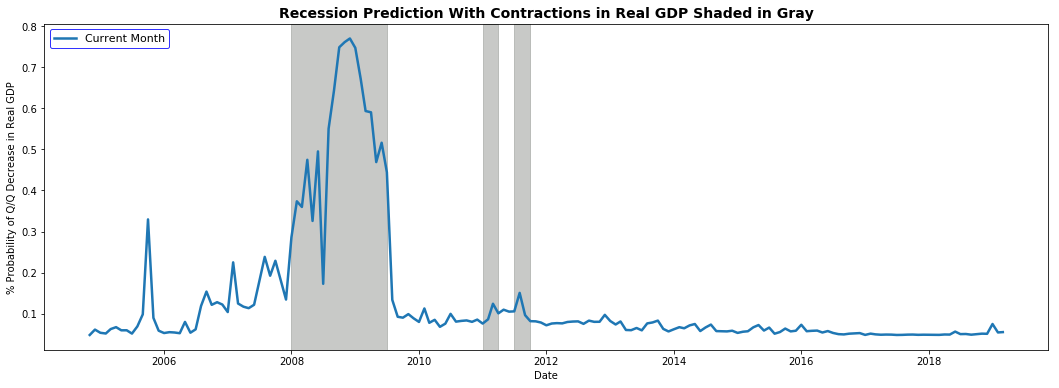

In [17]:
#generating chart

gen_results.create_chart(probs_chart,0)

In [20]:
performance = gen_results.create_probs(X,y,12,723,550,time, params)[1]

In [24]:
print(performance)

   Time_Horizon       AUC  Log_Loss
0           0.0  0.878076  0.266901
1          -1.0  0.842562  0.293302
2          -3.0  0.872483  0.306881
3         -12.0  0.726930  0.393345


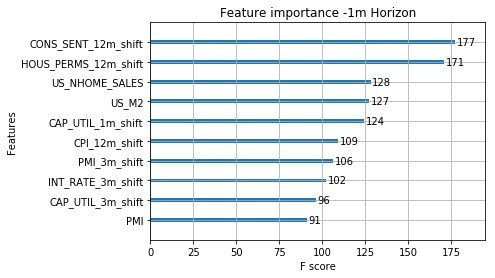

In [23]:
gen_results.create_feat_imp(X,y,12,723,550,-1, params)